In [7]:
!pip install !pip install tensorflow_io
!pip install keras-tuner
!pip install print_schema
!pip install pydub
!pip install opensmile
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install transformers

ERROR: Invalid requirement: '!pip'
  Using cached keras_tuner-1.1.3-py3-none-any.whl (135 kB)
  Using cached kt_legacy-1.0.4-py3-none-any.whl (9.6 kB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached Werkzeug-2.1.2-py3-none-any.whl (224 kB)
  Using cached absl_py-1.2.0-py3-none-any.whl (123 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached protobuf-3.19.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'message.py'
Consider using the `--user` option or check the permissions.

  Using cached print_schema-1.1.1-py3-none-any.whl (6.2 kB)
  Using cached pyd

In [62]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
import numpy as np
import pandas as pd
import gc

In [9]:
data = pd.read_csv("train.csv")
id = data.iloc[:,0].values
train_labels = data.iloc[:,1].values
train_texts = data.iloc[:,2].values

In [10]:
df = pd.read_csv("test.csv")
df["Content"].fillna("",inplace=True)
test_texts = list(df.loc[:,"Content"])
test_labels = list(df.loc[:,"Label"])

In [11]:
def find_pos_sample_frac(sample_label):
  return (sample_label == 1).sum() / sample_label.shape[0]

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
def get_several_validation_set(content, label, val_fraction=0.2, total_splits=5, seed=0):
  sss = StratifiedShuffleSplit(n_splits=total_splits, test_size=val_fraction, random_state=seed)
  return sss.split(content, label)

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
np.random.seed(42)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


## Visualization

In [10]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=20):
    """Create a sample plot for indices of a cross-validation object."""
 
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
 
        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
 
    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)
 
    # ax.scatter(range(len(X)), [ii + 2.5] * len(X),
    #            c=group, marker='_', lw=lw, cmap=cmap_data)
 
    # Formatting
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1.1, -.1], xlim=[0, 166])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

NameError: name 'content' is not defined

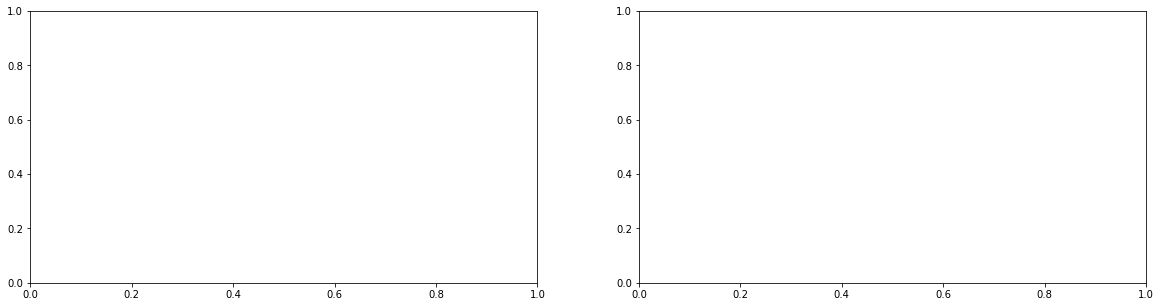

In [11]:
# groups = np.hstack([[ii] * 16 for ii in range(10)])
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
cv = StratifiedShuffleSplit(n_splits=4, test_size=0.2)
ax1 = plot_cv_indices(cv, content, label, ax1, 4)
file_keys_sorted_index = np.argsort(label)
ax2 = plot_cv_indices(cv, content[file_keys_sorted_index], label[file_keys_sorted_index], ax2, 4)
ax1.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(0, .95))
ax2.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(0, .95))
# Make the legend fit
# plt.tight_layout()
fig.subplots_adjust()
plt.show()


## Model

In [13]:
import torch
import torchvision
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/jupyter/.cache/torch/hub/huggingface_pytorch-transformers_main


In [14]:
class ADdataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [15]:
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 256, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            
            nn.Linear(D_in, 256),
            nn.BatchNorm1d(num_features=256), ## kk
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            #nn.BatchNorm1d(num_features=128),
            #nn.ReLU(),
            #nn.Linear(128, 1)
            
            #nn.BatchNorm1d(num_features=128), ###
            #nn.ReLU(),
            
            #nn.Dropout(0.5),

            #nn.Linear(H, D_out)
            #nn.Linear(128, 2)
            #nn.Linear(128, 1)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [16]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader


def initialize_model(epochs=50):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_loader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [17]:
import random
import time

# Specify loss function
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCELoss()
loss_fn =  torch.nn.BCEWithLogitsLoss()
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_loader, optim, val_loader=None, epochs=50, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = [] 
    for epoch_i in range(epochs):
        train_loss_sum = 0
        train_accuracy_epoch = 0
        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for batch in (train_loader):
            optim.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Perform a forward pass. This will return logits.
            logits = model(input_ids, attention_mask)

            # Compute loss and accumulate the loss values
            logits = logits.reshape(-1) #silebilirsin
            
            loss = loss_fn(logits, labels.float())
            train_loss_sum += loss.item()

            logits_class = logits > 0.5
            train_acc = (labels == logits_class).sum().item() / labels.size(0)
            train_accuracy_epoch += train_acc

            # Perform a backward pass to calculate gradients
            loss.backward()


            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

        avg_train_loss = np.round(train_loss_sum/len(train_loader),2)
        avg_train_acc = np.round(train_accuracy_epoch/len(train_loader),2)

        if evaluation == True:
            avg_val_loss, avg_val_acc = evaluate(model, val_loader)
        # print('Epoch {}, train loss {} , val loss is {}, train acc is {}, val acc is {} '.format(epoch_i,avg_train_loss,avg_val_loss,avg_train_acc,avg_val_acc))
        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        train_acc_list.append(avg_train_acc)

    print("Training complete!")
    return model,train_loss_list,val_loss_list,train_acc_list,val_acc_list


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_loss_sum = 0
    val_accuracy_epoch = 0
    # For each batch in our validation set...
    for batch in val_dataloader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      
      # Compute logits
      with torch.no_grad():
        logits = model(input_ids, attention_mask)

        # Compute loss
        logits = logits.reshape(-1)
        loss = loss_fn(logits, labels.float())
        val_loss_sum +=loss.item()
        avg_val_loss = np.round(val_loss_sum/len(val_dataloader),2)

        logits_class = logits > 0.5
        val_acc = (labels == logits_class).sum().item() / labels.size(0)
        val_accuracy_epoch += val_acc
        avg_val_acc = np.round(val_accuracy_epoch/len(val_dataloader),2)

    return avg_val_loss, avg_val_acc


def evaluate_test(model, test_dataloader):
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    test_loss_sum = 0
    test_accuracy_epoch = 0
    predictions = []
    labels_list = []
    for batch in test_dataloader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      
      # Compute logits
      with torch.no_grad():
        logits = model(input_ids, attention_mask)
        labels_list.append(labels.cpu())

        # Compute loss
        logits = logits.reshape(-1)
        loss = loss_fn(logits, labels.float())
        test_loss_sum +=loss.item()
        avg_test_loss = np.round(test_loss_sum/len(test_dataloader),5)

        logits_class = logits > 0.5
        predictions.append(logits.cpu())
        test_acc = (labels == logits_class).sum().item() / labels.size(0)
        test_accuracy_epoch += test_acc
        avg_test_acc = np.round(test_accuracy_epoch/len(test_dataloader),5)

    return avg_test_loss, avg_test_acc, predictions, labels_list

### Train alone to vote

In [69]:
for train_index, val_index in train_and_val_splits:
    print("new set: ")
    label_val_set = train_labels[val_index]
    print("Val set size ", val_index.shape[0] / train_labels.shape[0])
    print("Pos sample %: ", find_pos_sample_frac(label_val_set))
    print(" " * 5 + "TRAIN:", train_index[:5], "TEST:", val_index[:5])

new set: 
Val set size  0.20481927710843373
Pos sample %:  0.5294117647058824
     TRAIN: [160 146  51 130   3] TEST: [105 136  20  36 121]
new set: 
Val set size  0.20481927710843373
Pos sample %:  0.5294117647058824
     TRAIN: [ 92  11 119 155  50] TEST: [ 58  93  23 147   0]
new set: 
Val set size  0.20481927710843373
Pos sample %:  0.5294117647058824
     TRAIN: [ 95  25  61  18 113] TEST: [  2  22 117  10  23]
new set: 
Val set size  0.20481927710843373
Pos sample %:  0.5294117647058824
     TRAIN: [ 55  80  52  70 126] TEST: [146 155  17 149  23]
new set: 
Val set size  0.20481927710843373
Pos sample %:  0.5294117647058824
     TRAIN: [152 133 129  23 106] TEST: [ 44 121 101  29  85]


In [18]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = ADdataset(test_encodings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [18]:
# seeds = list(range(0,60,6))
mean_val_acc = {}
last_val_acc = {}
test_acc = {}
best_val_acc = 0
best_test_acc = 0

**Different seed || Multiple epoch**

**Single seed || Multiple epoch**

In [25]:
trains = []
vals = []

In [26]:
for train_index, val_index in train_and_val_splits:
    trains.append(train_index)
    vals.append(val_index)

In [37]:
len(trains)

11

In [23]:
gc.collect()
set_seed(42)    # Set seed for reproducibility
seed = 42
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mean_val_acc[seed] = []
last_val_acc[seed] = []
test_acc[seed] = []
models = []
index = 1
train_and_val_splits = get_several_validation_set(train_texts, train_labels, total_splits=20, seed=seed)
for train_index, val_index in train_and_val_splits:
    gc.collect()
    train_encodings = tokenizer(list(train_texts[train_index]), truncation=True, padding=True)
    val_encodings = tokenizer(list(train_texts[val_index]), truncation=True, padding=True)
    train_dataset = ADdataset(train_encodings, train_labels[train_index])
    val_dataset = ADdataset(val_encodings, train_labels[val_index])
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

    bert_classifier, optimizer, scheduler = initialize_model(epochs=20)
    bert_classifier,train_loss_list,val_loss_list,train_acc_list,val_acc_list = train(bert_classifier, train_loader, optimizer, val_loader, epochs=20, evaluation=True)

    max_val_acc = max(val_acc_list)
    if max_val_acc > best_val_acc:
        best_model_val = bert_classifier
        torch.save(best_model_val, "weights/bestModel_val.pt")


    test_loss, test_accuracy, predictions, labels_l = evaluate_test(bert_classifier, test_loader)
    print("Test Loss: {}, Test Accuracy: {}".format(test_loss,test_accuracy))

    if test_accuracy > best_test_acc:
        best_model_test = bert_classifier
        torch.save(best_model_test, "weights/bestModel_test.pt")
    torch.save(bert_classifier, f"weights/Model_{index}.pt")
    models.append(bert_classifier)
    index += 1
    

    mean_val_acc[seed].append(np.mean(val_acc_list))
    last_val_acc[seed].append(val_acc_list[-1])
    test_acc[seed].append(test_accuracy)
    gc.collect()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

Training complete!
Test Loss: 0.53905, Test Accuracy: 0.84524


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
Test Loss: 0.87953, Test Accuracy: 0.80159


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
Test Loss: 0.60234, Test Accuracy: 0.81548


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
Test Loss: 0.59169, Test Accuracy: 0.84524


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
Test Loss: 0.42473, Test Accuracy: 0.87302


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
Test Loss: 0.5463, Test Accuracy: 0.85913


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
Test Loss: 0.75432, Test Accuracy: 0.81746


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
Test Loss: 0.60126, Test Accuracy: 0.82937


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...



RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 14.76 GiB total capacity; 13.41 GiB already allocated; 41.75 MiB free; 13.65 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [35]:
gc.collect()
set_seed(42)    # Set seed for reproducibility
seed = 42
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# mean_val_acc[seed] = []
# last_val_acc[seed] = []
# test_acc[seed] = []
# models = []
index = 1
# train_and_val_splits = get_several_validation_set(train_texts, train_labels, total_splits=20, seed=seed)
for train_index, val_index in zip(trains, vals):
    if index < 11:
        index += 1
        continue
    gc.collect()
    train_encodings = tokenizer(list(train_texts[train_index]), truncation=True, padding=True)
    val_encodings = tokenizer(list(train_texts[val_index]), truncation=True, padding=True)
    train_dataset = ADdataset(train_encodings, train_labels[train_index])
    val_dataset = ADdataset(val_encodings, train_labels[val_index])
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

    bert_classifier, optimizer, scheduler = initialize_model(epochs=20)
    bert_classifier,train_loss_list,val_loss_list,train_acc_list,val_acc_list = train(bert_classifier, train_loader, optimizer, val_loader, epochs=20, evaluation=True)

    max_val_acc = max(val_acc_list)
    # if max_val_acc > best_val_acc:
    #     best_model_val = bert_classifier
    #     torch.save(best_model_val, "weights/bestModel_val.pt")


    test_loss, test_accuracy, predictions, labels_l = evaluate_test(bert_classifier, test_loader)
    print("Test Loss: {}, Test Accuracy: {}".format(test_loss,test_accuracy))

    # if test_accuracy > best_test_acc:
    #     best_model_test = bert_classifier
    #     torch.save(best_model_test, "weights/bestModel_test.pt")
    torch.save(bert_classifier, f"weights/Model_{index}.pt")
    # models.append(bert_classifier)
    index += 1
    

    mean_val_acc[seed].append(np.mean(val_acc_list))
    last_val_acc[seed].append(val_acc_list[-1])
    test_acc[seed].append(test_accuracy)
    gc.collect()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
Test Loss: 0.58624, Test Accuracy: 0.84524


In [36]:
print(mean_val_acc)
print(last_val_acc)
print(test_acc)

{42: [0.8564999999999999, 0.6935, 0.8185, 0.8730000000000002, 0.8805000000000002, 0.79, 0.7310000000000001, 0.7304999999999999, 0.7374999999999999, 0.8905, 0.8400000000000001]}
{42: [0.9, 0.78, 0.88, 0.92, 0.92, 0.75, 0.82, 0.75, 0.78, 0.95, 0.82]}
{42: [0.84524, 0.80159, 0.81548, 0.84524, 0.87302, 0.85913, 0.81746, 0.82937, 0.83135, 0.81746, 0.84524]}


2

In [31]:
def evaluate_ensemble(models, test_dataloader):
    test_loss_sum = 0
    test_accuracy_epoch = 0
    predictions = []
    labels_list = []
    for batch in test_dataloader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      prediction = []
      for model in models:
        model.eval()
        # Compute logits
        with torch.no_grad():
          logits = model(input_ids, attention_mask)
          labels_list.append(labels.cpu())

          # Compute loss
          logits = logits.reshape(-1)
          # loss = loss_fn(logits, labels.float())
          # test_loss_sum +=loss.item()
          # avg_test_loss = np.round(test_loss_sum/len(test_dataloader),5)

          logits_class = logits > 0.5
          prediction.append(logits_class)

      prediction_ensemble = sum(prediction) > 0.5*len(prediction)
      predictions.append(prediction_ensemble.cpu())

      test_acc = (labels == prediction_ensemble).sum().item() / labels.size(0)
      test_accuracy_epoch += test_acc
      avg_test_acc = np.round(test_accuracy_epoch/len(test_dataloader),5)

    return avg_test_acc, predictions, labels_list

In [42]:
mean_val_acc

{42: [0.8564999999999999,
  0.6935,
  0.8185,
  0.8730000000000002,
  0.8805000000000002,
  0.79,
  0.7310000000000001,
  0.7304999999999999,
  0.7374999999999999,
  0.8905,
  0.8400000000000001],
 0: [0.7885, 0.7945000000000001, 0.6014999999999999, 0.7679999999999999],
 10: [0.7704999999999999, 0.762, 0.8005000000000001, 0.7195],
 20: [0.7934999999999999, 0.7675000000000001, 0.8285000000000002, 0.7865],
 30: [0.7394999999999998, 0.8100000000000002, 0.7344999999999999, 0.7435],
 40: [0.7825, 0.8615, 0.7929999999999999, 0.7695000000000001]}

In [43]:
for seed in range(50,70,10):
    set_seed(seed)    # Set seed for reproducibility
    seed = seed
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    mean_val_acc[seed] = []
    last_val_acc[seed] = []
    test_acc[seed] = []
    # models = []
    index = 1
    train_and_val_splits = get_several_validation_set(train_texts, train_labels, total_splits=4, seed=seed)
    for train_index, val_index in train_and_val_splits:
        print(f"seed={seed}    index={index}")
        gc.collect()
        train_encodings = tokenizer(list(train_texts[train_index]), truncation=True, padding=True)
        val_encodings = tokenizer(list(train_texts[val_index]), truncation=True, padding=True)
        train_dataset = ADdataset(train_encodings, train_labels[train_index])
        val_dataset = ADdataset(val_encodings, train_labels[val_index])
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

        bert_classifier, optimizer, scheduler = initialize_model(epochs=20)
        bert_classifier,train_loss_list,val_loss_list,train_acc_list,val_acc_list = train(bert_classifier, train_loader, optimizer, val_loader, epochs=20, evaluation=True)

        # max_val_acc = max(val_acc_list)
        # if max_val_acc > best_val_acc:
        #     best_model_val = bert_classifier
        #     torch.save(best_model_val, "weights/bestModel_val.pt")


        test_loss, test_accuracy, predictions, labels_l = evaluate_test(bert_classifier, test_loader)
        # print("Test Loss: {}, Test Accuracy: {}".format(test_loss,test_accuracy))

        # if test_accuracy > best_test_acc:
        #     best_model_test = bert_classifier
        #     torch.save(best_model_test, "weights/bestModel_test.pt")
        torch.save(bert_classifier, f"different_seed/Model_{seed}_{index}.pt")
        # models.append(bert_classifier)
        index += 1


        mean_val_acc[seed].append(np.mean(val_acc_list))
        last_val_acc[seed].append(val_acc_list[-1])
        test_acc[seed].append(test_accuracy)
        gc.collect()

seed=50    index=1


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

Training complete!
seed=50    index=2


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
seed=50    index=3


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
seed=50    index=4


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
seed=60    index=1


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

Training complete!
seed=60    index=2


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
seed=60    index=3


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!
seed=60    index=4


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

Training complete!


In [51]:
gc.collect()
del test_models

In [5]:
from glob import glob
from tqdm import *

In [6]:
filenames = glob("different_seed/*.pt")

In [19]:
test_models = []
for filename in tqdm(filenames):
    test_models.append(torch.load(filename))

100%|██████████| 28/28 [02:46<00:00,  5.95s/it]


In [24]:
# val_loss = []
# val_acc = []
test_los = []
test_acc = []
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for test_model in tqdm(test_models):
    # avg_val_loss, avg_val_acc = evaluate(test_model, test_loader)
    test_loss, test_accuracy, predictions, labels_l = evaluate_test(test_model, test_loader)
    # val_loss.append(avg_val_loss)
    # val_acc.append(avg_val_acc)
    test_los.append(test_loss)
    test_acc.append(test_accuracy)

100%|██████████| 28/28 [01:30<00:00,  3.23s/it]


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

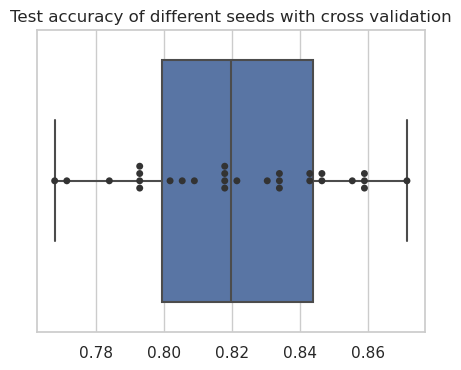

In [50]:
sns.set(font_scale=1,style="whitegrid",rc={'figure.dpi':100})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
ax.set_title("Test accuracy of different seeds with cross validation")
ax = sns.boxplot(x=test_acc)
ax = sns.swarmplot(x=test_acc, color=".2")

In [33]:
test_accuracy_ensemble, predictions_ensemble, labels_l_ensemble = evaluate_ensemble(test_models, test_loader)

In [34]:
test_accuracy_ensemble

0.85536